In [20]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import QED
from rdkit import RDLogger
from rdkit import Chem  # For molecule validation
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import functools
import torch
import torch.nn as nn
from torch.nn.functional import one_hot
from torch.utils.data import Dataset, DataLoader

from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from IPython.display import display
from PIL import Image 
import PIL 
import re

RDLogger.DisableLog('rdApp.*') 


__special__ = {0: "<PAD>", 1: "<BOS>", 2: "<EOS>"}
# Checking for MPS availability
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
def preprocess_smiles(input_file, output_file):
    # Read the original SMILES file
    smiles_data = pd.read_csv(input_file, usecols=[0])
    
    # Prepare lists to store valid SMILES, LogP, and QED
    valid_smiles = []
    logp_list = []
    qed_list = []
    total_smiles = len(smiles_data)  # Total number of SMILES in the input file

    for sm in tqdm(smiles_data.iloc[:, 0].dropna().tolist(), desc="Processing SMILES"):
        mol = Chem.MolFromSmiles(sm)
        if mol:  # Check if the molecule is valid
            valid_smiles.append(sm)
            logp = Descriptors.MolLogP(mol)
            qed = QED.qed(mol)
            logp_list.append(logp)
            qed_list.append(qed)
    
    # Create a DataFrame with the valid SMILES
    processed_data = pd.DataFrame({
        'SMILES': valid_smiles,
        'LogP': logp_list,
        'QED': qed_list
    })
    
   
    processed_data.to_csv(output_file, index=False)
    print(f"Preprocessed data saved to {output_file}") 
    
    # Calculate % valid SMILES
    valid_percentage = (len(valid_smiles) / total_smiles) * 100
    print(f"Percentage of valid SMILES: {valid_percentage:.2f}%")

preprocess_smiles('smiles_CHEMBL_22', 'processed_smiles_data_kaggle.csv')

Processing SMILES:   0%|                 | 1923/542672 [00:03<14:13, 633.59it/s]


KeyboardInterrupt: 

In [3]:
class Smiles_data(torch.utils.data.Dataset):
    def __init__(self, file, total=130):
        self.total = total
        
        # Load the preprocessed dataset with SMILES and target variables
        data = pd.read_csv(file).iloc[:self.total]
        
        self.smiles = data['SMILES'].tolist()
        self.logp_qed = data[['LogP', 'QED']].values.tolist()
        
        tokens = functools.reduce(lambda acc, s: acc.union(set(s)), self.smiles, set())
        self.vocsize = len(tokens) + len(__special__)
        self.index2token = dict(enumerate(tokens, start=3))
        self.index2token.update(__special__)
        self.token2index = {v: k for k, v in self.index2token.items()}
        
        self.ints = [torch.LongTensor([self.token2index[s] for s in line]) for line in tqdm(self.smiles, "Preparing the dataset")]

    def decode(self, indexes):
        return "".join([self.index2token[index] for index in indexes if index not in __special__])

    def __getitem__(self, i):
        special_added = torch.cat((
            torch.LongTensor([self.token2index['<BOS>']]),
            self.ints[i],
            torch.LongTensor([self.token2index['<EOS>']]),
        ), dim=0)
        
        logp, qed = self.logp_qed[i]  # Get the LogP and QED values for the current index
        return one_hot(special_added, self.vocsize).float(), special_added, torch.tensor([logp, qed], dtype=torch.float32)

    def __len__(self):
        return len(self.smiles)


def pad_collate_fn(batch):
    seq_len = max([item[1].size(0) for item in batch])
    padded_batch = []
    properties = []

    for one_hot_seq, special_added, props in batch:
        pad_length = seq_len - special_added.size(0)
        padded_special_added = torch.cat([
            special_added,
            torch.LongTensor([0] * pad_length)
        ])
        padded_one_hot_seq = one_hot(padded_special_added, one_hot_seq.size(1)).float()
        padded_batch.append((padded_one_hot_seq, padded_special_added))
        properties.append(props)
    
    one_hot_tensors = torch.stack([item[0] for item in padded_batch])
    special_added_tensors = torch.stack([item[1] for item in padded_batch])
    properties = torch.stack(properties)
    
    return one_hot_tensors, special_added_tensors, properties

In [4]:
class SmilesVAE(nn.Module):
    def __init__(self, vocab_size, latent_dim=20, hidden_size=64):
        super(SmilesVAE, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_size = hidden_size
        
        # Encoder
        self.encoder_lstm = nn.LSTM(vocab_size, hidden_size, batch_first=True)
        self.fc_mu = nn.Linear(hidden_size, latent_dim)
        self.fc_logvar = nn.Linear(hidden_size, latent_dim)
        
        # Decoder
        self.decoder_lstm = nn.LSTM(latent_dim, int(hidden_size/2), batch_first=True)
        self.fc_out = nn.Linear(int(hidden_size/2), vocab_size)
        
        # Predictor for LogP and QED (2 outputs)
        self.predictor = nn.Sequential(
            nn.Linear(latent_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2)  # 2 outputs for LogP and QED
        )

    def encode(self, x):
        _, (hidden, _) = self.encoder_lstm(x)  # Learns hidden representation of the input vector x
        mu = self.fc_mu(hidden[-1])  # Use hidden representation to determine the center of the latent distribution (mean)
        logvar = self.fc_logvar(hidden[-1])  # Use hidden representation to determine the spread of the latent distribution (variance)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):  # To sample from the distribution and ensure differentiability, use the reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * (std + 1e-10)
        return z  # z is the sampled latent vector
    
    def decode(self, z, seq_len=10, tokenizer=None, temp=1.0):
        batch_size = z.size(0)
        generated_seq = torch.full((batch_size, 1), tokenizer['<BOS>'], dtype=torch.long, device=z.device)
        hidden_state = None

        logits_list = []

        for t in range(seq_len):
            z_rep = z.unsqueeze(1).repeat(1, generated_seq.size(1), 1)
            output, hidden_state = self.decoder_lstm(z_rep, hidden_state)
            logits = self.fc_out(output[:, -1, :])  # Get logits for the last time step
            logits_list.append(logits)

            next_token_probs = torch.softmax(logits / temp, dim=-1)
            next_token = torch.multinomial(next_token_probs, 1)

            generated_seq = torch.cat((generated_seq, next_token), dim=1)

        logits = torch.stack(logits_list, dim=1)

        # Retrieve <EOS> and <PAD> token indices from tokenizer
        eos_token = tokenizer['<EOS>']
        pad_token = tokenizer['<PAD>']

        # Stop generation after EOS token is encountered
        mask = torch.cumsum((generated_seq == eos_token).float(), dim=1)
        generated_seq = generated_seq.masked_fill(mask > 0, pad_token)

        return logits, generated_seq

    def forward(self, x, tokenizer, seq_len=10):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        logits, _ = self.decode(z, seq_len=seq_len, tokenizer=tokenizer)
        
        # Predict LogP and QED
        predicted_properties = self.predictor(z)
        
        return logits, mu, logvar, predicted_properties

In [5]:
def vae_loss_function(reconstructed_seq, original_seq, mu, logvar, predicted_properties, true_properties, epoch, n_epochs):
    # Flatten the tensors for CrossEntropyLoss
    flat_reconstructed_seq = reconstructed_seq.view(-1, reconstructed_seq.size(-1))  # (batch_size * seq_len, vocab_size)
    flat_original_seq = original_seq.view(-1)  # (batch_size * seq_len)
    
    # Define a mask for the padding sequences
    pad_mask = original_seq != 0  
    
    # Ensure reconstruction loss uses float logits and long target
    reconstruction_loss = nn.CrossEntropyLoss(reduction='none')(flat_reconstructed_seq, flat_original_seq.long())
    
    # Construct the loss without the padding mask
    reconstruction_loss = reconstruction_loss[pad_mask.view(-1)].mean()
    
    # KL Divergence
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Predictor loss (MSE Loss)
    property_loss = nn.MSELoss()(predicted_properties, true_properties)

    # Define beta for KL annealing
    beta = min(1.0, epoch / (n_epochs * 0.4))  # KL annealing

    # Construct the total loss
    total_loss = reconstruction_loss + (beta * kl_divergence) + property_loss
    
    return total_loss, reconstruction_loss.item(), kl_divergence.item(), property_loss.item()

In [6]:
def plot_and_save_losses(epoch_reconstruction_losses, epoch_kl_divergences, epoch_property_losses, n_epochs):
    """
    Plots and saves the reconstruction loss, KL divergence, and property loss across epochs.
    """
    epochs = list(range(1, n_epochs + 1))
    
    # Plot Reconstruction Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, epoch_reconstruction_losses, label="Reconstruction Loss")
    plt.plot(epochs, epoch_kl_divergences, label="KL Divergence")
    plt.plot(epochs, epoch_property_losses, label="Property Loss (LogP/QED)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Losses Over Epochs")
    plt.legend()
    plt.grid(True)
    
    # Save the plot
    plt.savefig("figs/vae_training_losses.png")
    plt.show()

    # Save the losses to a CSV file
    df_losses = pd.DataFrame({
        "Epoch": epochs,
        "Reconstruction Loss": epoch_reconstruction_losses,
        "KL Divergence": epoch_kl_divergences,
        "Property Loss": epoch_property_losses
    })
    df_losses.to_csv("csv_logs/vae_training_losses.csv", index=False)
    print("Training losses saved to vae_training_losses.csv and vae_training_losses.png")

def train_vae(train_file, batch_size=32, learning_rate=0.001, n_epochs=50, latent_dim=40, hidden_size=128, subset_size=50):
    save_file = f"vae_pred_subset{subset_size}_latent{latent_dim}_hidden{hidden_size}_epochs{n_epochs}.pt"
    
    dataset = Smiles_data(train_file, total=subset_size)
    
    model = SmilesVAE(dataset.vocsize, latent_dim, hidden_size).to(device)
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    epoch_reconstruction_losses = []
    epoch_kl_divergences = []
    epoch_property_losses = []

    for epoch in range(1, n_epochs + 1):
        total_loss = 0.
        total_reconstruction_loss = 0.
        total_kl_divergence = 0.
        total_property_loss = 0.

        for iteration, (batch, target, true_properties) in enumerate(tqdm(dataloader, 'Training')):
            batch, target, true_properties = batch.to(device), target.to(device), true_properties.to(device)
            model.train()
            seq_len = target.size(1)  # Get the sequence length from the target sequence
            reconstructed_seq, mu, logvar, predicted_properties = model(batch, dataset.token2index, seq_len=seq_len)
            
            loss, reconstruction_loss, kl_divergence, property_loss = vae_loss_function(
                reconstructed_seq, target, mu, logvar, predicted_properties, true_properties, epoch, n_epochs
            )

            total_loss += loss.item()
            total_reconstruction_loss += reconstruction_loss
            total_kl_divergence += kl_divergence
            total_property_loss += property_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_reconstruction_losses.append(total_reconstruction_loss / len(dataloader))
        epoch_kl_divergences.append(total_kl_divergence / len(dataloader))
        epoch_property_losses.append(total_property_loss / len(dataloader))

        print(f"Epoch {epoch} of {n_epochs} done, total loss: {total_loss}")

    # Plot and save the losses
    plot_and_save_losses(epoch_reconstruction_losses, epoch_kl_divergences, epoch_property_losses, n_epochs)

    torch.save({'tokenizer': dataset.index2token, 'model': model.cpu()}, f"models/{save_file}")
    print(f"VAE Training Complete! Model saved as {save_file}")

# Example call to the modified training function
subset_size = 150000
train_vae(train_file='processed_smiles_22.csv', batch_size=32, n_epochs=35, latent_dim=60, hidden_size=256, subset_size=subset_size)

Training:   0%|                              | 3/4688 [00:06<2:46:21,  2.13s/it]


KeyboardInterrupt: 

In [9]:
# Function to decode token indices into SMILES
def decode_from_indices(token_indices, tokenizer):
    # Join tokens into a string and remove any unwanted special tokens
    smiles = "".join([tokenizer.get(i, '') for i in token_indices if i not in __special__])
    
    # Remove any unwanted characters like tabs or newlines from the generated string
    smiles = smiles.replace('\t', '').replace('\n', '').strip()
    
    return smiles

def validate_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            return True
    except:
        print(f"SMILES parsing failed: {smiles}")
        return False


def generate_molecules(model, tokenizer, num_samples, seq_len, target_logp=None, target_qed=None, temp=1.0, max_temp=1.05, max_attempts=500):
    model.eval()  # Set model to evaluation mode
    
    generated_smiles = []
    unique_smiles = set()  # Set to track unique SMILES
    token2index = {v: k for k, v in tokenizer.items()}  # Reverse tokenizer mapping
    
    try:
        eos_token_index = token2index['<EOS>']  # Retrieve the index for the <EOS> token
    except KeyError:
        raise KeyError("The '<EOS>' token is missing in the tokenizer.")
    
    initial_temp = temp  
    sample_idx = 0
    attempts = 0  
    
    while sample_idx < num_samples:
        if attempts >= max_attempts:  
            new_temp = min(temp * 1.01, max_temp)  # Increase temperature but cap it
            if new_temp != temp:
                temp = new_temp
                print(f"Increasing temperature to {round(temp,3)} for more diversity")
            attempts = 0 
        
        # Sample from the prior (standard normal) with applied temperature scaling
        z = torch.randn(1, model.latent_dim) * temp  # Shape: (1, latent_dim)

        # Check if we have target values to aim for
        if target_logp is not None and target_qed is not None:
            # Iteratively adjust z to aim for the target properties (e.g., through gradient descent)
            z = aim_for_target_properties(model, z, target_logp, target_qed)
        
        # Decode the latent vector to generate logits and the token sequence
        logits, sampled_tokens = model.decode(z, seq_len=seq_len, tokenizer=token2index, temp=temp)  # Pass token2index
        
        # Convert token indices back to SMILES string
        token_indices = sampled_tokens[0].tolist()  # Take the first (and only) sample from batch
        if eos_token_index in token_indices:
            token_indices = token_indices[:token_indices.index(eos_token_index)]  # Stop at <EOS>
        
        smiles = decode_from_indices(token_indices, tokenizer)
        
        # Validate SMILES string
        if validate_smiles(smiles):
            if smiles not in unique_smiles:
                print(f"Valid unique SMILES: {smiles}")
                generated_smiles.append(smiles)
                unique_smiles.add(smiles)
                sample_idx += 1
                attempts = 0  # Reset attempts counter after successful generation
                temp = initial_temp  # Reset temperature to initial value
            else:
                attempts += 1  # Increment attempts
        else:
            attempts += 1  # Increment attempts for invalid SMILES
    
    return generated_smiles

def aim_for_target_properties(model, z, target_logp, target_qed, lr=0.01, steps=10):
    z = z.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([z], lr=lr)
    
    for _ in range(steps):
        optimizer.zero_grad()
        predicted_properties = model.predictor(z)
        predicted_logp, predicted_qed = predicted_properties[0]

        # Loss to guide z towards the target properties
        loss = ((predicted_logp - target_logp) ** 2 + (predicted_qed - target_qed) ** 2)
        loss.backward()
        optimizer.step()
    
    return z.detach()

# Example usage
if __name__ == "__main__":
    # Load the trained model and tokenizer
    checkpoint = torch.load('models/vae_pred_subset150000_latent60_hidden256_epochs35.pt')
    model = checkpoint['model']
    tokenizer = checkpoint['tokenizer']
    
    # Define target properties
    target_logp = 1.8
    target_qed = 0.6
    
    # Generate 
    num_samples = 11
    temperature = 0.55
    seq_len = 11
    generated_smiles = generate_molecules(model, tokenizer, num_samples, seq_len, target_logp=target_logp, target_qed=target_qed, temp=temperature)
    df = pd.DataFrame(generated_smiles, columns=["SMILES"])
    df.to_csv(f"molecules/generated_molecules_len{seq_len}.csv", index=False)
    
    print(f"Generated {len(generated_smiles)} valid molecules and saved to generated_molecules.csv")
    print(df)

Valid unique SMILES: CC1=cCCCO1
Valid unique SMILES: CCc1cCCcc1
Valid unique SMILES: CCCCCC2Cc2
Valid unique SMILES: CC1CCcCcC1
Valid unique SMILES: Cc1CCCCCc1
Valid unique SMILES: CC1CNccCC1
Valid unique SMILES: CNC1ccCcc1
Valid unique SMILES: COCCCc1cC1
Valid unique SMILES: CCCCC1cC1C
Valid unique SMILES: CNc1CcCCC1
Valid unique SMILES: COC1OCc1CC
Generated 11 valid molecules and saved to generated_molecules.csv
        SMILES
0   CC1=cCCCO1
1   CCc1cCCcc1
2   CCCCCC2Cc2
3   CC1CCcCcC1
4   Cc1CCCCCc1
5   CC1CNccCC1
6   CNC1ccCcc1
7   COCCCc1cC1
8   CCCCC1cC1C
9   CNc1CcCCC1
10  COC1OCc1CC


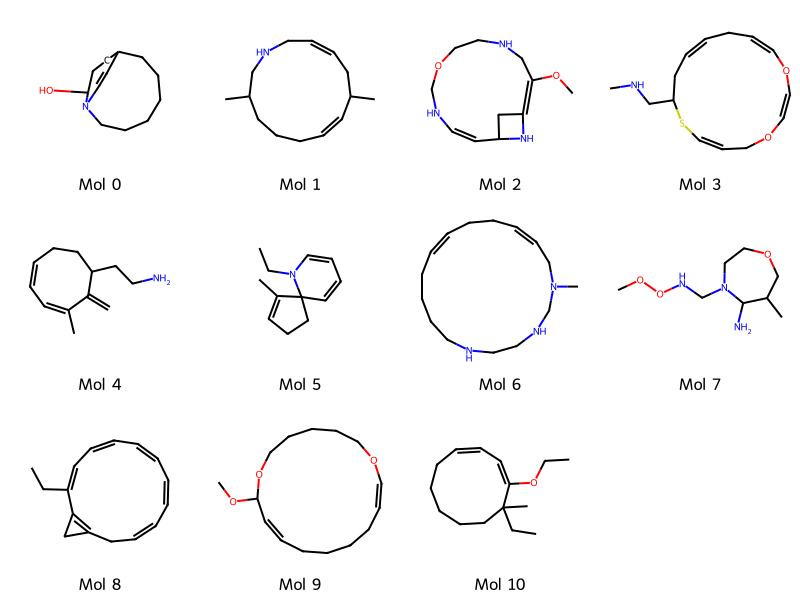

In [24]:
def visualize_smiles_molecules(file_path):
    # Extract length from the filename 
    match = re.search(r'len(\d+)', file_path)
    mol_len = match.group(1) if match else "unknown"
    
    df = pd.read_csv(file_path)
    
    # Extract SMILES
    smiles_list = df.iloc[:, 0].tolist()
    
    
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list if smiles]
    
    # Visualize the molecules
    img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200, 200), legends=[f"Mol {i}" for i in range(len(mols))],returnPNG=False)
    
    img.save(f'figs/molecules_len{mol_len}.png')
    display(img)

visualize_smiles_molecules('molecules/generated_molecules_len21.csv')

### Sequence Length 

In [39]:
def compute_sampling_efficiency(generated_smiles, total_attempts):
    """
    Computes the sampling efficiency of the model.

    Sampling efficiency is defined as the ratio of valid unique SMILES strings
    to the total number of attempts made during the sampling process.

    Args:
        generated_smiles (list): A list of valid unique SMILES strings.
        total_attempts (int): Total number of sampling attempts.

    Returns:
        float: The sampling efficiency as a percentage.
    """
    num_unique_smiles = len(generated_smiles)
    if total_attempts == 0:
        return 0.0
    return (num_unique_smiles / total_attempts) * 100


def generate_molecules_with_efficiency(model, tokenizer, num_samples, seq_len, target_logp=None, target_qed=None, temp=0.55, max_temp=1.05, max_attempts=500):
    model.eval()  # Set model to evaluation mode
    
    generated_smiles = []
    unique_smiles = set()  # Set to track unique SMILES
    token2index = {v: k for k, v in tokenizer.items()}  # Reverse tokenizer mapping
    total_attempts = 0  

    try:
        eos_token_index = token2index['<EOS>'] 
    except KeyError:
        raise KeyError("The '<EOS>' token is missing in the tokenizer.")
    
    initial_temp = temp  
    sample_idx = 0
    attempts = 0  
    
    while sample_idx < num_samples:
        if attempts >= max_attempts:  
            new_temp = min(temp * 1.01, max_temp)  
            if new_temp != temp:
                temp = new_temp
                print(f"Increasing temperature to {round(temp,3)} for more diversity")
            attempts = 0 
        
        # Sample from the prior (standard normal) with applied temperature scaling
        z = torch.randn(1, model.latent_dim) * temp  # Shape: (1, latent_dim)

        # Check if we have target values to aim for
        if target_logp is not None and target_qed is not None:
            # Iteratively adjust z to aim through gradient descent
            z = aim_for_target_properties(model, z, target_logp, target_qed)
        
        # Decode the latent vector to generate logits and the token sequence
        logits, sampled_tokens = model.decode(z, seq_len=seq_len, tokenizer=token2index, temp=temp)  # Pass token2index
        
        # Convert token indices back to SMILES string
        token_indices = sampled_tokens[0].tolist()  # Take the first (and only) sample from batch
        if eos_token_index in token_indices:
            token_indices = token_indices[:token_indices.index(eos_token_index)]  # Stop at end token
        
        smiles = decode_from_indices(token_indices, tokenizer)
        
        # Validation segment
        if validate_smiles(smiles):
            if smiles not in unique_smiles:
                print(f"Valid unique SMILES: {smiles}")
                generated_smiles.append(smiles)
                unique_smiles.add(smiles)
                sample_idx += 1
                attempts = 0  # Reset attempts counter after successful generation
                temp = initial_temp  # Reset temperature to initial value
            else:
                attempts += 1  
        else:
            attempts += 1  
        
        total_attempts += 1
    
    sampling_efficiency = compute_sampling_efficiency(generated_smiles, total_attempts)
    df = pd.DataFrame(generated_smiles, columns=["SMILES"])
    df.to_csv(f"molecules/generated_molecules_len{seq_len}.csv", index=False)
    print(f"Sampling efficiency for seq_len {seq_len}: {sampling_efficiency:.2f}%")

    return generated_smiles, sampling_efficiency


def evaluate_sampling_efficiency_across_seq_lengths(model, tokenizer, num_samples_per_seq_len, seq_len_range, target_logp=None, target_qed=None, temp=1.0):
    """
    Evaluates sampling efficiency across a range of sequence lengths and saves the results.

    Args:
        model: Trained model to generate molecules.
        tokenizer: Tokenizer for converting indices to SMILES strings.
        num_samples_per_seq_len (int): Number of samples to generate per sequence length.
        seq_len_range (list): A list of sequence lengths to evaluate.
        target_logp: Optional target logP value for property-based generation.
        target_qed: Optional target QED value for property-based generation.
        temp (float): Initial temperature for sampling.

    Returns:
        pd.DataFrame: DataFrame containing seq_len and sampling efficiency values.
    """
    results = []

    for seq_len in seq_len_range:
        print(f"Evaluating seq_len = {seq_len}")
        _, sampling_efficiency = generate_molecules_with_efficiency(
            model, tokenizer, num_samples_per_seq_len, seq_len, target_logp=target_logp, target_qed=target_qed, temp=temp
        )
        results.append({'seq_len': seq_len, 'sampling_efficiency': sampling_efficiency})
    
    
    df_results = pd.DataFrame(results)
    df_results.to_csv("sampling_efficiency_per_seq_len.csv", index=False)
    print("Saved sampling efficiency results to sampling_efficiency_per_seq_len.csv")

    
    plt.figure(figsize=(10, 6))
    plt.plot(df_results['seq_len'], df_results['sampling_efficiency'], marker='o')
    plt.xlabel('Sequence Length')
    plt.ylabel('Sampling Efficiency')
    plt.title('Sampling Efficiency vs Sequence Length')
    plt.grid(True)
    plt.savefig("figs/seq_len_eff.png",dpi=300)
    plt.show()

    return df_results


# Example usage
if __name__ == "__main__":
    # load
    checkpoint = torch.load('models/vae_pred_subset150000_latent100_hidden256_epochs8.pt')
    model = checkpoint['model']
    tokenizer = checkpoint['tokenizer']
    
    # Define targets
    target_logp = 2.0
    target_qed = 0.6
    
    # Evaluate sampling efficiency across a range of sequence lengths
    seq_len_range = range(3, 18, 1)  # Sequence lengths from 10 to 50, in steps of 5
    num_samples_per_seq_len = 10  # Generate 10 samples for each sequence length
    
    df_efficiency = evaluate_sampling_efficiency_across_seq_lengths(
        model, tokenizer, num_samples_per_seq_len, seq_len_range, target_logp=target_logp, target_qed=target_qed
    )

    print(df_efficiency)


Evaluating seq_len = 3
Valid unique SMILES: CC
Valid unique SMILES: OC
Valid unique SMILES: CO
Valid unique SMILES: ON
Valid unique SMILES: CN
Valid unique SMILES: NO
Valid unique SMILES: NC
Valid unique SMILES: FC
Valid unique SMILES: CS
Valid unique SMILES: OO
Sampling efficiency for seq_len 3: 22.73%
Evaluating seq_len = 4
Valid unique SMILES: CCC
Valid unique SMILES: OCN
Valid unique SMILES: COC
Valid unique SMILES: OSO
Valid unique SMILES: CNC
Valid unique SMILES: ClC
Valid unique SMILES: FNC
Valid unique SMILES: SCC
Valid unique SMILES: CNN
Valid unique SMILES: CON
Sampling efficiency for seq_len 4: 16.13%
Evaluating seq_len = 5
Valid unique SMILES: OSCC
Valid unique SMILES: CCCC
Valid unique SMILES: COCC
Valid unique SMILES: ClCC
Valid unique SMILES: ONCC
Valid unique SMILES: CCCN
Valid unique SMILES: CNOP
Valid unique SMILES: NCCC
Valid unique SMILES: NNCC
Valid unique SMILES: CNCC
Sampling efficiency for seq_len 5: 7.75%
Evaluating seq_len = 6
Valid unique SMILES: CCC=C
Valid 

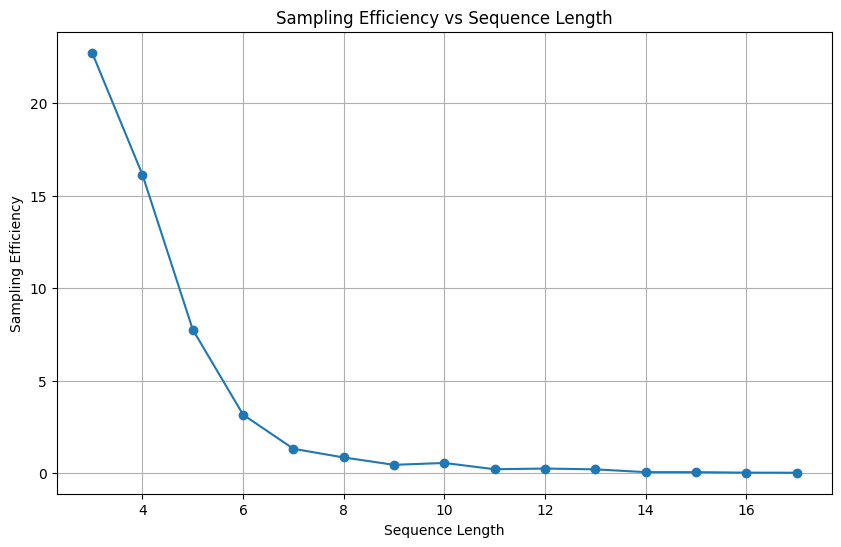

In [22]:
def plot_sampling_efficiency(csv_path):
    data = pd.read_csv(csv_path)
    
    plt.figure(figsize=(10, 6))
    plt.plot(data['seq_len'], data['sampling_efficiency'], marker='o')
    plt.xlabel('Sequence Length')
    plt.ylabel('Sampling Efficiency')
    plt.title('Sampling Efficiency vs Sequence Length')
    plt.grid(True)
    plt.savefig("figs/seq_len_eff.png",dpi=300)
    plt.show()

plot_sampling_efficiency('csv_logs/sampling_efficiency_per_seq_len.csv')